<a href="https://colab.research.google.com/github/tuancompa2610/Predict-Mexico-House-Price/blob/main/Predict_Mexico_House_Price_Main.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1. Data Preparation

In [1]:
# Import libraries
!pip install category_encoders

from glob import glob
import plotly.express as px
import plotly.graph_objects as go
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

from category_encoders import OneHotEncoder
from ipywidgets import Dropdown, FloatSlider, IntSlider, interact
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.metrics import mean_absolute_error
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.2/81.2 KB 2.7 MB/s eta 0:00:00


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
def wrangle(file_path):
    df = pd.read_csv(file_path, index_col = 0)
    mask_apt = df["place_with_parent_names"].str.contains("Distrito Federal")
    mask_price = df["price_aprox_usd"] < 100000
    mask_prt = df["property_type"] == "apartment"
    df = df[mask_apt & mask_price & mask_prt]
    low, high = df["surface_covered_in_m2"].quantile([0.1, 0.9])
    mask_area = df["surface_covered_in_m2"].between(low, high)
    df = df[mask_area]
    df[["lat", "lon"]] = df["lat-lon"].str.split(",", expand = True).astype(float)
    df["borough"] = df["place_with_parent_names"].str.split("|", expand = True)[1]
    df.drop(columns = ["lat-lon", "place_with_parent_names"], inplace = True)
    df.drop(columns = ["price_usd_per_m2", "expenses", "floor", "rooms", 
                       "surface_total_in_m2"], inplace =True)
    df.drop(columns = ["operation", "property_type","properati_url", "currency"],
            inplace = True)
    df.drop(columns = ["price_aprox_local_currency", "price", "price_per_m2"],
            inplace =True)
    return df

In [7]:
df = wrangle("/content/drive/MyDrive/mexico-house/mexico-city-real-estate-1.csv")
df.head()

,price_aprox_usd,surface_covered_in_m2,lat,lon,borough
12,94022.66,57.0,23.634501,-102.552788,Benito Juárez
21,70880.12,56.0,19.402413,-99.095391,Iztacalco
22,68228.99,80.0,19.357820,-99.149406,Benito Juárez
23,24235.78,60.0,19.504985,-99.208557,Azcapotzalco
27,94140.20,50.0,19.354219,-99.126244,Coyoacán


In [8]:
file = glob("/content/drive/MyDrive/mexico-house/mexico-city-real-estate-*")
files = [wrangle(i) for i in file]

In [9]:
df = pd.concat(files)
print(df.info())
df.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5473 entries, 12 to 4619
Data columns (total 5 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   price_aprox_usd        5473 non-null   float64
 1   surface_covered_in_m2  5473 non-null   float64
 2   lat                    5149 non-null   float64
 3   lon                    5149 non-null   float64
 4   borough                5473 non-null   object 
dtypes: float64(4), object(1)
memory usage: 256.5+ KB
None


,price_aprox_usd,surface_covered_in_m2,lat,lon,borough
12,94022.66,57.0,23.634501,-102.552788,Benito Juárez
21,70880.12,56.0,19.402413,-99.095391,Iztacalco
22,68228.99,80.0,19.357820,-99.149406,Benito Juárez
23,24235.78,60.0,19.504985,-99.208557,Azcapotzalco
27,94140.20,50.0,19.354219,-99.126244,Coyoacán


# 2. EDA

Text(0.5, 1.0, 'Distribution of Apartment Prices')

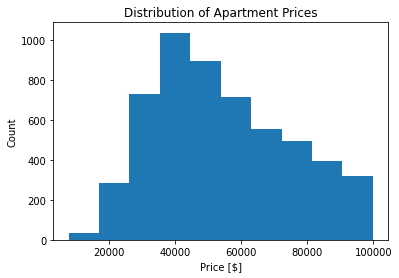

In [11]:
# Build histogram
plt.hist(df["price_aprox_usd"])


# Label axes
plt.xlabel("Price [$]")
plt.ylabel("Count")
# Add title
plt.title("Distribution of Apartment Prices")

Text(0.5, 1.0, 'Mexico City: Price vs. Area')

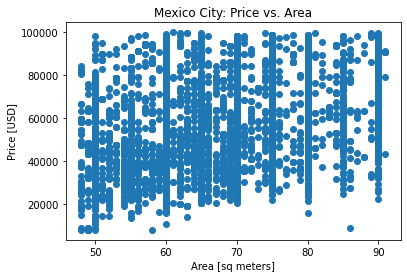

In [12]:
# Build scatter plot
plt.scatter(df["surface_covered_in_m2"], df["price_aprox_usd"])

# Label axes
plt.xlabel("Area [sq meters]")
plt.ylabel("Price [USD]")
# Add title
plt.title("Mexico City: Price vs. Area")

In [13]:
fig = px.scatter_mapbox(
    df, 
    lat = "lat",
    lon = "lon",
    width = 600,
    height = 600,
    color = "price_aprox_usd",
    hover_data = ["price_aprox_usd"]
)

fig.update_layout(mapbox_style = "open-street-map")
fig.show()

# 3. Split Data

### Split Data

In [15]:
target = "price_aprox_usd"
X = df.drop(columns = [target])
y = df[target]
print("X shape:", X.shape)
print("y shape:", y.shape)

X shape: (5473, 4)
y shape: (5473,)


In [16]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size = 0.2, 
                                                 random_state = 42)
print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
print("X_test shape:", X_val.shape)
print("y_test shape:", y_val.shape)

X_train shape: (4378, 4)
y_train shape: (4378,)
X_test shape: (1095, 4)
y_test shape: (1095,)


In [17]:
y_mean = y_train.mean()
y_pred_baseline = [y_mean]*len(y_train)
mae_baseline = mean_absolute_error(y_pred_baseline, y_train)
print("Baseline MAE:", round(mae_baseline, 2))

Baseline MAE: 17189.62


# 4. Build Model

### 3.1 Linear Regression

In [18]:
model_lr = make_pipeline(OneHotEncoder(), SimpleImputer(), LinearRegression())
# Fit model
model_lr.fit(X_train, y_train)

Pipeline(steps=[('onehotencoder', OneHotEncoder(cols=['borough'])),
                ('simpleimputer', SimpleImputer()),
                ('linearregression', LinearRegression())])

In [19]:
y_pred = model_lr.predict(X_val)
print("Training MAE:", mean_absolute_error(y_val, y_pred))

Training MAE: 15200.969446104538


In [20]:
X_test = pd.read_csv("/content/drive/MyDrive/mexico-house/mexico-city-test-features.csv", index_col = 0)
y_pred_test = pd.Series(model_lr.predict(X_test))
y_pred_test.head()

0    53588.941004
1    53038.395826
2    34799.701208
3    53532.179160
4    68958.292201
dtype: float64

Communicate Results

In [21]:
intercept = model_lr.named_steps["linearregression"].intercept_
coefficients = model_lr.named_steps["linearregression"].coef_
print("coefficients len:", len(coefficients))
print(coefficients[:5])  # First five coefficients

coefficients len: 18
[  281.91289499   892.26805309 -2441.32279475  1956.10284251
 13617.76239004]


In [22]:
feature_names = model_lr.named_steps["onehotencoder"].get_feature_names_out()
print("features len:", len(feature_names))
print(feature_names[:5])  # First five feature names

features len: 18
['surface_covered_in_m2', 'lat', 'lon', 'borough_1', 'borough_2']


In [24]:
feat_imp = pd.Series(coefficients, index = feature_names)
feat_imp.head()

surface_covered_in_m2      281.912895
lat                        892.268053
lon                      -2441.322795
borough_1                 1956.102843
borough_2                13617.762390
dtype: float64

In [25]:
print(f"price = {intercept.round(2)}")
for f, c in feat_imp.items():
    print(f"+ ({round(c, 2)} * {f})")

price = -224868.35
+ (281.91 * surface_covered_in_m2)
+ (892.27 * lat)
+ (-2441.32 * lon)
+ (1956.1 * borough_1)
+ (13617.76 * borough_2)
+ (-4803.95 * borough_3)
+ (-14079.93 * borough_4)
+ (-13420.71 * borough_5)
+ (10719.7 * borough_6)
+ (3076.37 * borough_7)
+ (1904.15 * borough_8)
+ (-1287.22 * borough_9)
+ (-1007.69 * borough_10)
+ (-4319.65 * borough_11)
+ (-7238.41 * borough_12)
+ (2666.38 * borough_13)
+ (-534.99 * borough_14)
+ (12752.08 * borough_15)


Text(0.5, 1.0, 'Feature Importance for Apartment Price')

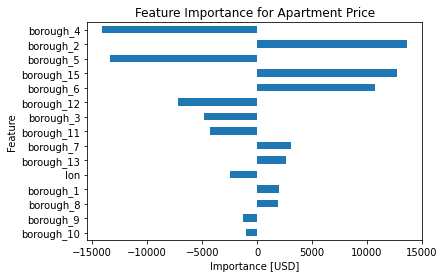

In [26]:
feat_imp.sort_values(key=abs).tail(15).plot(kind = "barh")
plt.xlabel("Importance [USD]")
plt.ylabel("Feature")
plt.title("Feature Importance for Apartment Price")

### 3.2 Ridge

In [27]:
model_ridge = make_pipeline(OneHotEncoder(), SimpleImputer(), Ridge())
model_ridge.fit(X_train, y_train)

Pipeline(steps=[('onehotencoder', OneHotEncoder(cols=['borough'])),
                ('simpleimputer', SimpleImputer()), ('ridge', Ridge())])

In [28]:
y_pred = model_ridge.predict(X_val)
print("Training MAE:", mean_absolute_error(y_val, y_pred))

Training MAE: 15200.246518925875


In [29]:
y_pred_test = pd.Series(model_ridge.predict(X_test))
y_pred_test.head()

0    53578.239440
1    53017.876609
2    34828.408498
3    53521.439103
4    68939.926021
dtype: float64

Communicate Results

In [30]:
coefficients = model_ridge.named_steps["ridge"].coef_
features = model_ridge.named_steps["onehotencoder"].get_feature_names_out()
feat_imp = pd.Series(coefficients, index = features)
feat_imp

surface_covered_in_m2      282.608340
lat                        885.350311
lon                      -2451.438015
borough_1                 1988.526258
borough_2                13632.729427
borough_3                -4744.686435
borough_4               -13915.767167
borough_5               -13340.841584
borough_6                10689.861171
borough_7                 3101.566307
borough_8                 1937.515193
borough_9                -1246.237298
borough_10                -961.817925
borough_11               -4056.135823
borough_12               -7173.193649
borough_13                2694.959313
borough_14                -483.257779
borough_15               11876.779993
dtype: float64

In [31]:
feat_imp = pd.Series(coefficients, index = feature_names)
feat_imp.head()

surface_covered_in_m2      282.608340
lat                        885.350311
lon                      -2451.438015
borough_1                 1988.526258
borough_2                13632.729427
dtype: float64

Text(0.5, 1.0, 'Feature Importance for Apartment Price')

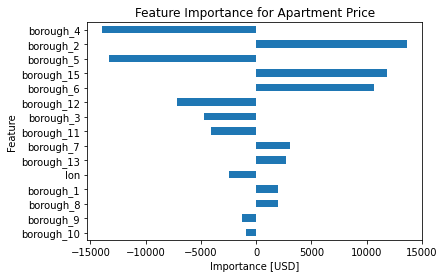

In [32]:
feat_imp.sort_values(key=abs).tail(15).plot(kind = "barh")
plt.xlabel("Importance [USD]")
plt.ylabel("Feature")
plt.title("Feature Importance for Apartment Price")